<a href="https://colab.research.google.com/github/arizonaCameraLab/computationalImaging/blob/master/inverseProblems/demosaickingSiren.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demosaicking using SIREN networks
## David Brady
## University of Arizona
## September 2023

# Siren Networks

This notebook uses the network and concepts described  Sitzmann, Vincent, et al. "Implicit neural representations with periodic activation functions." Advances in neural information processing systems 33 (2020): 7462-7473. The code used here was downloaded from in  [Implicit Neural Activations with Periodic Activation Functions](https://vsitzmann.github.io/siren) on github.



This notebook uses a Siren to reconstruct a Bayer color image by learning the base cell $\begin{smallmatrix}GR\\BG\\ \end{smallmatrix}$ on a regular grid and then reconstructing the missing color samples by interpolation at up sampled values of the grid. The input to the nework is the grid position $xy$. The output is the 4 element GRBG vector at that grid position. The output thus produces green, blue and red images shifted by one pixel relative to each other. Shifting the images back in composition produces the estimated frame.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
import cv2
from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize, PILToTensor
import numpy as np
import skimage
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid



### mosaic sampling

In [ ]:
def rgb2bayerGR2(image):
  w,h, c=image.shape
  bayer=np.zeros((w,h))
  bayer[0:w:2,0:h:2]=image[0:w:2,0:h:2,1]
  bayer[1:w:2,1:h:2]=image[1:w:2,1:h:2,1]
  bayer[0:w:2,1:h:2]=image[0:w:2,1:h:2,0]
  bayer[1:w:2,0:h:2]=image[1:w:2,0:h:2,2]
  bayer=255*bayer/np.max(bayer)
  bayer=bayer.astype('uint8')
  return bayer

## Siren models

The sine layer is the basic building block of SIREN.

In [ ]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

Differential operators leverage autograd to compute gradients, the laplacian, etc.

In [ ]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

# Demosaicking Example


In [ ]:
def get_image_tensor():
    #img = Image.fromarray(skimage.data.astronaut())
    img = Image.open('kodim05.png')
    transform = Compose([
        PILToTensor()
    ])
    img = transform(img)
    img=img[:,:,:512]/255.
    return img

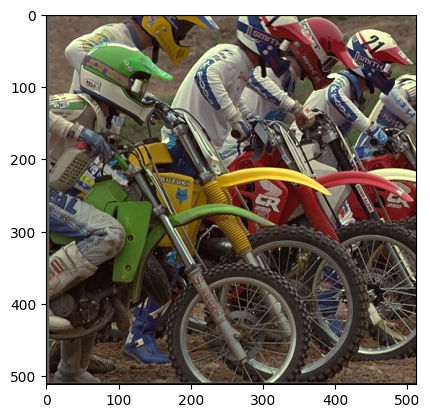

In [ ]:
pop=get_image_tensor()
pip=pop.permute(1,2,0).numpy()
plt.imshow(pip)

## Fitting the image with a SIREN


That is we seek the function $\Phi$ such that:
$\mathcal{L}=\int_{\Omega} \lVert \Phi(\mathbf{x}) - f(\mathbf{x}) \rVert\mathrm{d}\mathbf{x}$
 is minimized, in which $\Omega$ is the domain of the image.

RGBimagefitting calculates per-pixel coordinates and the 4 element RGBG data element at each pixel

In [ ]:
class RGBImageFitting(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        img=get_image_tensor()
        self.pixelsGRGB = torch.stack([img[1, ::2,::2], img[0, ::2,1::2],  img[2, 1::2,::2], img[1, 1::2,1::2]])
        self.pixelsGRGB= self.pixelsGRGB.permute(1,2,0)
        self.pixelsGRGB= self.pixelsGRGB.reshape(-1,4)
        self.coords = get_mgrid(np.uint16(sidelength/2), 2)
        #self.coords = get_mgrid(32, 2)
    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0: raise IndexError

        return self.coords, self.pixelsGRGB

Instantiate the dataset and our Siren. As pixel coordinates are 2D, the siren has 2 input features and 4 GRBG output channels

In [ ]:
motorBikes = RGBImageFitting(512)
dataloader = DataLoader(motorBikes, batch_size=1, pin_memory=True, num_workers=0, shuffle=True)

img_siren = Siren(in_features=2, out_features=4, hidden_features=512,
                  hidden_layers=3, outermost_linear=True)
img_siren.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=512, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
    (4): Linear(in_features=512, out_features=4, bias=True)
  )
)

We now fit Siren in a simple training loop. Within only hundreds of iterations, the image and its gradients are approximated well.

In [ ]:
total_steps = 1000 #
steps_til_summary = 50

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    model_output, coords = img_siren(model_input)
    loss = ((model_output - ground_truth)**2).mean()

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))

    optim.zero_grad()
    loss.backward()
    optim.step()

Step 0, Total loss 0.147411
Step 50, Total loss 0.012477
Step 100, Total loss 0.009511
Step 150, Total loss 0.007783
Step 200, Total loss 0.006564
Step 250, Total loss 0.005594
Step 300, Total loss 0.004661
Step 350, Total loss 0.003855
Step 400, Total loss 0.003121
Step 450, Total loss 0.002547
Step 500, Total loss 0.002092
Step 550, Total loss 0.001640
Step 600, Total loss 0.001325
Step 650, Total loss 0.001158
Step 700, Total loss 0.000946
Step 750, Total loss 0.000776
Step 800, Total loss 0.000639
Step 850, Total loss 0.000557
Step 900, Total loss 0.000459
Step 950, Total loss 0.000460


## estimating the image
We up sample on estimation by using a larger scale sampling grid

In [ ]:
upModel, coords=img_siren(get_mgrid(513, 2).cuda())

In [ ]:
pop=upModel.cpu().detach().numpy()

In [ ]:
green1=np.reshape(pop[:,0],(513,513))
green2=np.reshape(pop[:,3],(513,513))
red=np.reshape(pop[:,1],(513,513))
blue=np.reshape(pop[:,2],(513,513))

The shift in the 4 color planes in the estimate is illustrated by image differences. The green planes are shifted on the diagonal

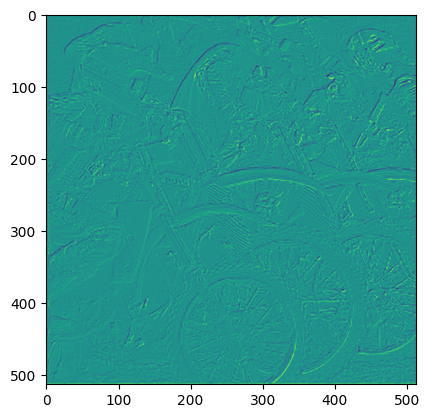

In [ ]:
plt.imshow(green1-green2)

shifting the planes along the diagonal prior to taking the difference reduces the difference

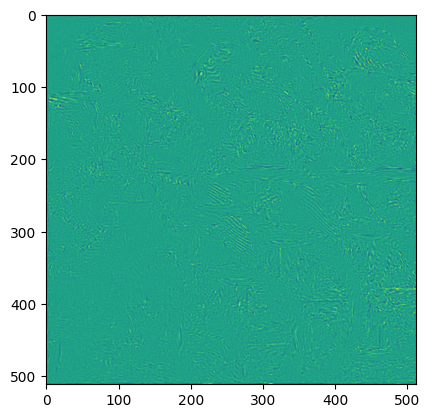

In [ ]:
plt.imshow(green2[:512,:512]-green1[1:,1:])

Green and red are shifted horizontally

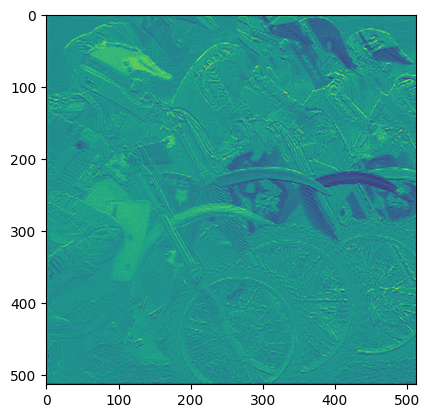

In [ ]:
plt.imshow(green2-red)

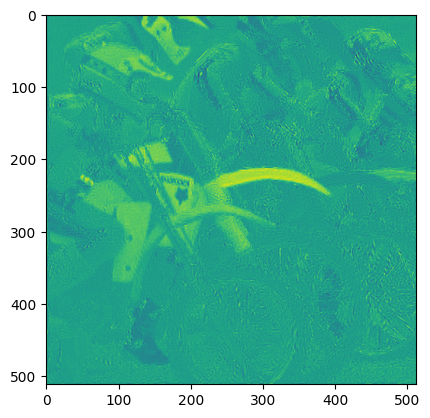

In [ ]:
plt.imshow(green2[:512,:512]-blue[:512,1:])

In [ ]:
recon=np.stack((red[1:,:512], (green2[:512,:512]+green1[1:,1:])/2,blue[:512,1:]), axis=-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


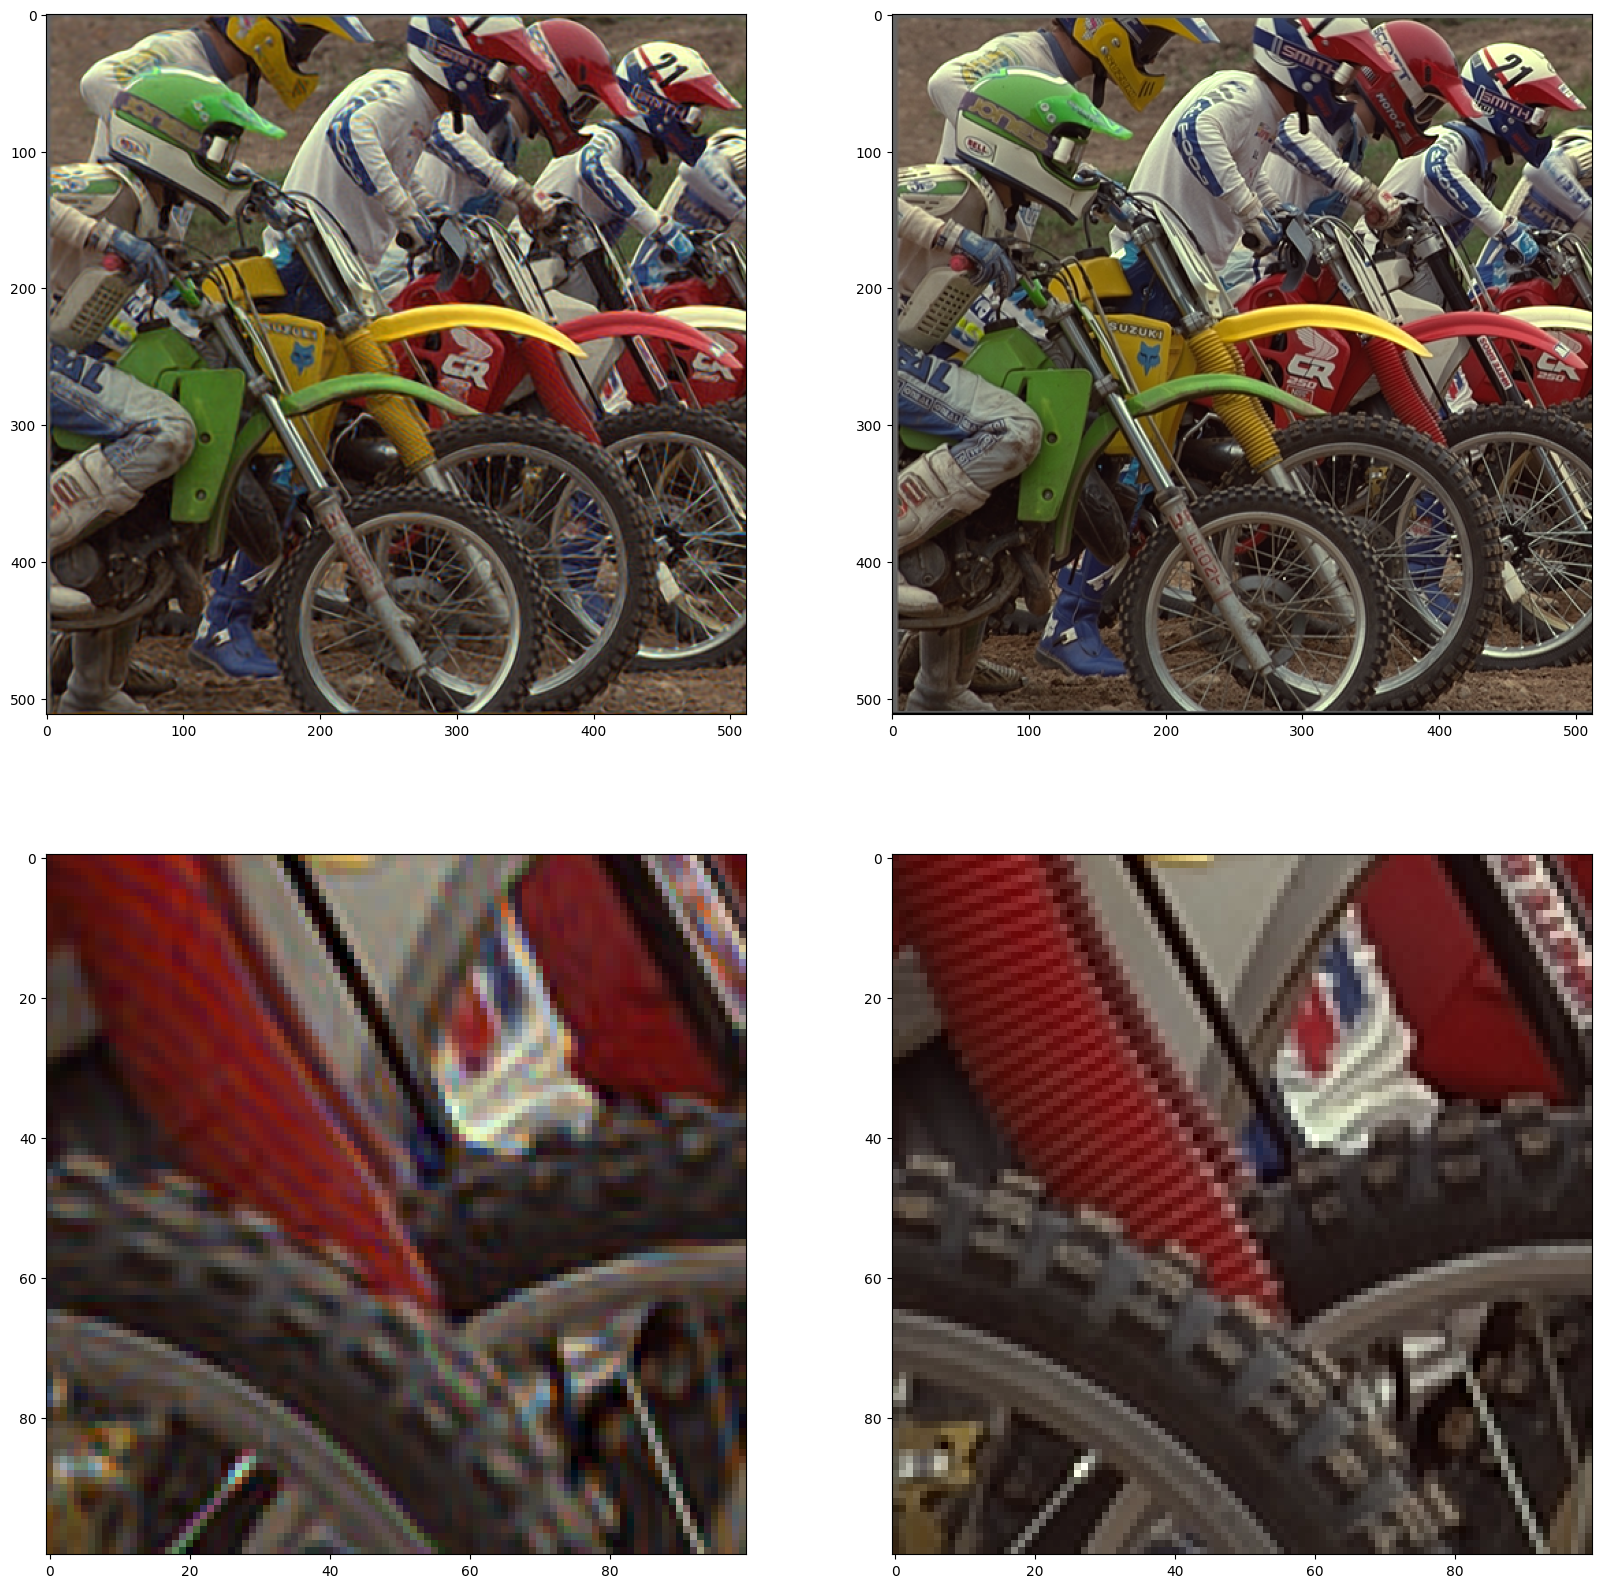

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(recon)
plt.subplot(2,2,2)
plt.imshow(pip)
plt.subplot(2,2,3)
plt.imshow(recon[250:350,350:450,:])
plt.subplot(2,2,4)
plt.imshow(pip[250:350,350:450,:])

In [ ]:
psnr(pip,recon)

22.278636193187523

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


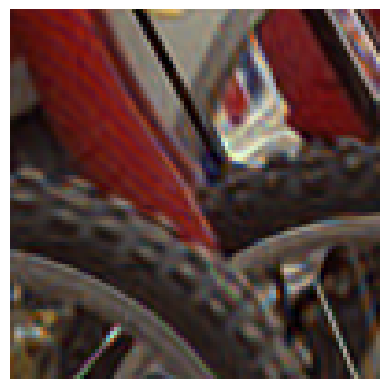

In [ ]:
plt.imshow(recon[250:350,350:450,:])
plt.axis('off')
plt.savefig('cycleDetailINR.pdf')